# Querying DAYMET data using polygons from the SNAP Data API

In the notebook below, we demonstrate a method for fetching a polygon of interest from the SNAP Data API and then using this polygon to subset DAYMET precipitation data. The intention is to show how these resources can be combined to support scientific inquiry in a reproducible notebook environment. By only querying the data we need in our area of interest, our analysis also becomes more efficient because we do not have to download complete datasets and process them locally.


### Setup:

Load required packages.

In [ ]:
from pydap.client import open_url
import xarray as xr
import geopandas as gpd
from ardac_utils import *
import requests
import shapely
import json
import numpy as np
import regionmask
import rioxarray

### Define area of interest using a polygon:

From our web browser, we can search the available HUC polygons at https://earthmaps.io/places/hucs for 'Chena River'. We decide to choose the HUC8 polygon (the one with an 8-digit ID), and from its properties below we get its HUC8 code '19080306':

...
```
{
    "id": "19080306",
    "name": "Chena River",
    "type": "huc"
  },
```
...

Use the HUC8 code to query the SNAP Data API and get a GeoJSON response. Parse the response into a EPSG:4326 geodataframe, and then reproject this to a second geodataframe in the Lambert Conformal Conic projection. (Here we use the PROJ string derived from the DAYMET projection details [here](https://daac.ornl.gov/DAYMET/guides/Daymet_Daily_V4.html#datacharact:~:text=PROJ.4%3A%20%2Bproj%3Dlcc%20%2Blat_1%3D25%20%2Blat_2%3D60%20%2Blat_0%3D42.5%20%2Blon_0%3D%2D100%20%2Bx_0%3D0%20%2By_0%3D0%20%2Bellps%3DWGS84%20%2Bunits%3Dm%20%2Bno_defs)) 

We will find the projected bounding box coordinates of the Lambert polygon which can be used to subset the DAYMET data. 

In [40]:
proj_str = '+proj=lcc +lat_1=25 +lat_2=60 +lat_0=42.5 +lon_0=-100 +x_0=0 +y_0=0 +ellps=WGS84 +units=m +no_defs'

with requests.Session() as s:
    response = s.get('https://earthmaps.io/boundary/area/19080306').json()
    response['the_geom'] = shapely.from_geojson(json.dumps(response))
    gdf_4326 = (gpd.GeoDataFrame([response]).set_geometry('the_geom').set_crs(4326))
    gdf_lambert = gdf_4326.to_crs(proj_str)

#order of bounding box coords is bottom left longitude, bottom left latitude, top right longitude, top right latitude 
bounds = gdf_lambert.total_bounds
x1, y1, x2, y2 = bounds[0], bounds[1], bounds[2], bounds[3]
print(x1, y1, x2, y2)

-2245166.7777520954 3025186.521815246 -2081741.944063858 3099636.0811854852


### DAYMET Background:

According to their [homepage](https://www.earthdata.nasa.gov/technology/daymet), the DAYMET project dataset "provides long-term, continuous, gridded estimates of daily weather and climatology variables from ground-based observations through statistical modeling techniques". DAYMET data is available through Oak Ridge National Laboratory Distributed Active Archive Center (ORNL DAAC), which houses and distributes a large variety of NASA data. (Read more [here](https://daac.ornl.gov/about/).)

When attempting to query these datasets programmatically, it helps to find the source DOI in the ORNL DAAC catalog. We are looking for DAYMET daily data for continental North America, which we find at this DOI: ```https://doi.org/10.3334/ORNLDAAC/2129```. Looking at the the DOI URL suffix, we can see that the dataset identifier in the ORNL DAAC catalog is ```2129```. This identifier is important, as it will become part of the URL we will build to query the ORNL DAAC THREDDS server.

While there are several data access services available on the ORNL DAAC THREDDS server, we are going to use the OPeNDAP access option to get our data. The URL structure for all OPeNDAP requests is as follows:

-  ```https://thredds/dodsC/ornldaac/<dataset_id>/<filename>```

And the filename structure is as follows:

- ```daymet_v4_daily_<region>_<variable>_<year>.nc```

_(We found this by browsing through the ORNL-DAAC catalog until we got to an individual item's page, and noting it's OPeNDAP access URL pattern. See [this page](https://thredds.daac.ornl.gov/thredds/catalog/ornldaac/2129/catalog.html?dataset=2129/daymet_v4_daily_na_prcp_1996.nc) for an example item, and check out the OPeNDAP URL structure under "Access", item #1.)_  


DAYMET has 3 regions of interest. The choices are:

- na: continental North America
- hi: Hawaii
- pr: Puerto Rico

DAYMET has 7 variables. The choices are:

- all: all variables below
- dayl: duration of daylight
- prcp: daily total precipitation
- srad: incident shortwave radiation flux density (average over daylight period)
- swe: snow water equivalent
- tmax: maximum 2-meter air temperature
- tmin: minimum 2-meter air temperature
- vp: water vapor pressure (daily average)
_(listed here: https://daymet.ornl.gov/single-pixel-tool-guide#:~:text=Variables%20and%20Units%3A)_

### Requesting DAYMET data:

First we define our request parameters, then we can build a list of request URLs that will fetch the data for us. We need to use multiple URLs because the DAYMET data files are split by year, and we need to make a unique request for each year of interest.

In [52]:
dataset_id = '2129'
region = 'na'
var = 'prcp'
start_year, end_year = 2000, 2003
years = [str(y) for y in range(start_year, end_year+1)]

urls = []
for y in years:
    filename = 'daymet_v4_daily_' + region + '_' + var + '_' + y + '.nc'
    url = 'https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/' + dataset_id + '/' + filename
    urls.append(url)

for url in urls:
    print(url)

https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/2129/daymet_v4_daily_na_prcp_2000.nc
https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/2129/daymet_v4_daily_na_prcp_2001.nc
https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/2129/daymet_v4_daily_na_prcp_2002.nc
https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/2129/daymet_v4_daily_na_prcp_2003.nc


Now we iterate through our list of URLs and request the DAYMET data. Note that the OPeNDAP protocol allows us to make a request and interact with the attributes of the dataset without actually downloading the file. This gives us the opportunity to subset the data to our area of interest before downloading, which is good because each yearly file is multiple gigabytes in size.

In the code snippet below, we know that our URL contains the year of interest. We also have the previously defined bounding box coordinates available to subset spatially. For the sake of this demo, let's also limit our request to May through October.

Once the dataset object has been created and subset by time and space, we will reproject the dataset to WGS84 geographic coordinates. (This will allow us to use the `regionmask` tools in later steps). Finally, we will rename one of the original coordinates to prevent any confusion with the CRS information in the reprojected dataset.

What we end up with is a list of xarray datasets, one for each year (2000-2003).

In [42]:
datasets = []

for url in urls:
    daymet_opendap = open_url(url)
    ds = xr.open_dataset(xr.backends.PydapDataStore(daymet_opendap), decode_coords="all")
    #crop to chena huc8 extent using the geographic bounds....
    #since xarray dataset coords start the top left corner (instead of bottom left, like on a map),
    #we use the max latitude as the minimum value for the slice, and the min latitude as the maximum value for the slice
    #also crop to include only months may thru oct
    ds = ds.sel(y=slice(y2,y1), x=slice(x1,x2), time=ds.time.dt.month.isin([5,6,7,8,9,10]))
    #now that we have a smaller slice of the data, we can reproject it
    ds4326 = ds.drop(['lon', 'lat']).rio.reproject("EPSG:4326").rio.write_crs("EPSG:4326")
    #clean up the dataset by renaming the spatial reference coordinate to something more general, since we just reproojected it
    ds4326 = ds4326.rename({'lambert_conformal_conic' : 'spatial_ref'})

    datasets.append(ds4326)


# TESTING of `regionmask`

In [43]:
#grab the DAYMET year 2000 data that has been clipped to chena river huc8 bbox
chena_bbox_2000 = datasets[0]
chena_bbox_2000

<xarray.Dataset>
Dimensions:      (time: 184, x: 179, y: 64)
Coordinates:
  * time         (time) datetime64[ns] 2000-05-01T12:00:00 ... 2000-10-31T12:...
  * x            (x) float64 -148.2 -148.2 -148.2 ... -144.7 -144.7 -144.6
  * y            (y) float64 65.57 65.55 65.53 65.51 ... 64.36 64.34 64.32 64.3
    spatial_ref  int64 0
Data variables:
    yearday      (time) int16 ...
    prcp         (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    start_year:                      2000
    source:                          Daymet Software Version 4.0
    Version_software:                Daymet Software Version 4.0
    Version_data:                    Daymet Data Version 4.0
    Conventions:                     CF-1.6
    citation:                        Please see http://daymet.ornl.gov/ for c...
    references:                      Please see http://daymet.ornl.gov/ for c...
    DODS_EXTRA.Unlimited_Dimension:  time

In [44]:
# create a 3 dimensional regionmask from the chena huc8 geodataframe.
# this geodataframe must be in geographic coordinates! I don't think these tools work with projected coordinates!
# We don't actually need to provide a third dimension, but we do need to provide lon/lat info
# from our target dataset. This basically creates an XY grid that the polygon area will be interpolated onto, to create the mask
chena_huc8_mask = regionmask.mask_3D_geopandas(gdf_4326, chena_bbox_2000.x, chena_bbox_2000.y)

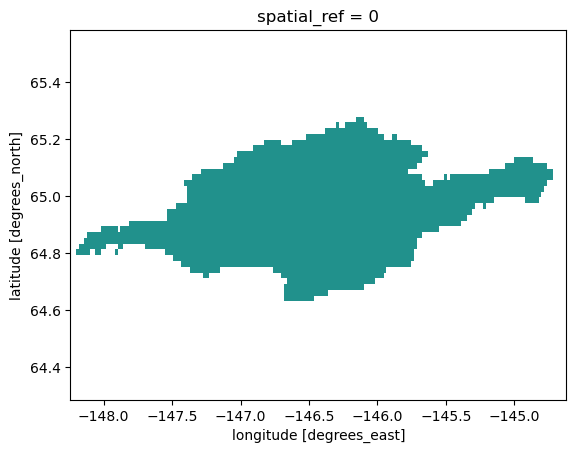

In [45]:
# plot gdf and mask to compare our shape
gdf_4326.plot()

In [ ]:
regionmask.plot_3D_mask(chena_huc8_mask, add_colorbar=False)

In [46]:
#apply the 3D mask to the DAYMET dataset... this clips the dataset in every time slice
chena_huc8 = chena_bbox_2000.where(chena_huc8_mask)
chena_huc8

<xarray.Dataset>
Dimensions:      (time: 184, region: 1, y: 64, x: 179)
Coordinates:
  * time         (time) datetime64[ns] 2000-05-01T12:00:00 ... 2000-10-31T12:...
  * x            (x) float64 -148.2 -148.2 -148.2 ... -144.7 -144.7 -144.6
  * y            (y) float64 65.57 65.55 65.53 65.51 ... 64.36 64.34 64.32 64.3
    spatial_ref  int64 0
  * region       (region) int64 0
Data variables:
    yearday      (time, region, y, x) float32 nan nan nan nan ... nan nan nan
    prcp         (time, y, x, region) float32 nan nan nan nan ... nan nan nan
Attributes:
    start_year:                      2000
    source:                          Daymet Software Version 4.0
    Version_software:                Daymet Software Version 4.0
    Version_data:                    Daymet Data Version 4.0
    Conventions:                     CF-1.6
    citation:                        Please see http://daymet.ornl.gov/ for c...
    references:                      Please see http://daymet.ornl.gov/ for c...
    DODS_EXTRA.Unlimited_Dimension:  time

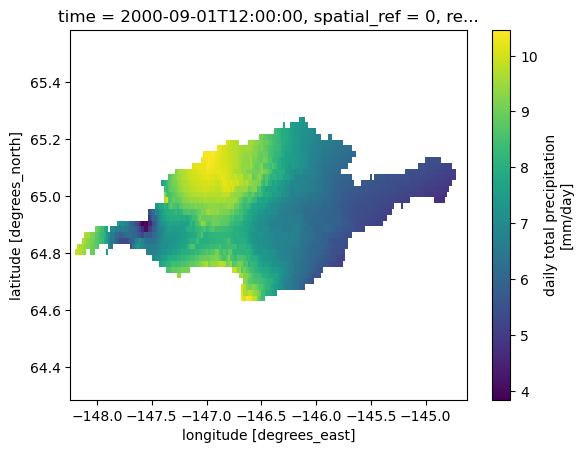

In [47]:
#plot precip variable on a date
chena_huc8.prcp.sel(time='2000-09-01').plot()

In [50]:
#compute a 7 day rolling sum across the masked dataset
prcp_7day_sum = chena_huc8['prcp'].rolling(time=7, center=True).sum()

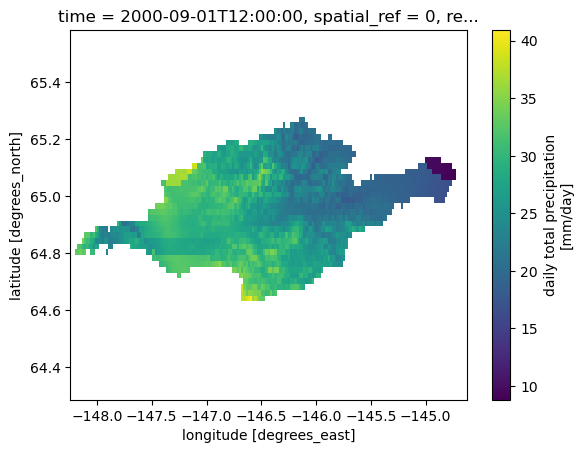

In [51]:
#plot the summed data on the same date
prcp_7day_sum.sel(time='2000-09-01').plot()